# Weak field limit: SU(2) lattice simulations

In this notebook we run simulations of the dilute Glasma, which can be then compared to our analytic results.

In the first half of this notebook we compute transverse momentum broadening. In the second half we compute the chromo-electric and chromo-magnetic field correlators at $\tau = 0$.

## Momentum broadening

First we import all the necessary packages and define some functions that we'll use later to simulate.

In [4]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# This line is necessary, because cupy otherwise doesn't find
# the cuda installation path. This is probably a configuration
# issue and should be removed on other machines.
os.environ["CUDA_PATH"] = "/usr/local/cuda-9.0"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.kappa as kappa
import curraun.qhat as qhat
from curraun.energy import Energy
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

In [5]:
def compute(p):    
    # output dictionary
    output = {}
    output["p_qhat"] = []
    output["p_kappa"] = []
    output["energy"] = []
    
    output["EL"] = []
    output["BL"] = []
    output["ET"] = []
    output["BT"] = []
    
    output["pL"] = []
    output["pT"] = []
    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    
    # event loop
    for e in range(p['NE']):
        # initialization
        # print("Initializating ...")
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        initial.init(s, va, vb)

        # print("Memory of data: {} GB".format(s.get_ngb()))

        # initialize transport computation
        kappa_tforce = kappa.TransportedForce(s)
        qhat_tforce = qhat.TransportedForce(s)
        
        # initialize energy computation
        en = Energy(s)

        # temporary results
        p_qhat = []
        p_kappa = []
        
        EL = []
        BL = []
        ET = []
        BT = []
        
        energy = []
        pL = []
        pT = []

        if use_cuda:
            s.copy_to_device()
            kappa_tforce.copy_to_device()
            qhat_tforce.copy_to_device()

            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))
        
        with tqdm(total=maxt, file=sys.stdout, miniters=128) as pbar:
            for t in range(maxt):
                core.evolve_leapfrog(s)
                
                if t % p['DTS'] == 0:
                    if use_cuda:
                        # Copy data from device to host
                        kappa_tforce.copy_mean_to_host()
                        qhat_tforce.copy_mean_to_host()

                    # unit factors (GeV^2)
                    units = E0 ** 2 / (s.g ** 2)

                    # color factors (for quarks)
                    Nc = core.su.NC
                    f = 2 * s.g ** 2 / (2 * Nc)

                    p_qhat.append(qhat_tforce.p_perp_mean * units * f)
                    p_kappa.append(kappa_tforce.p_perp_mean * units * f)

                    # Energy density calculation
                    en.compute()
                    
                    # unit factors (GeV^3)
                    units = E0 ** 3
                    EL.append(en.EL_mean * units)
                    BL.append(en.BL_mean * units)
                    ET.append(en.ET_mean * units)
                    BT.append(en.BT_mean * units)
                    
                    # unit factors (Gev / fm^3)
                    units = E0 ** 4 / hbarc ** 3
                    energy.append(en.energy_density * units)
                    pL.append(en.pL * units)
                    pT.append(en.pT * units)
                    
                    if use_cuda:
                        # Copy data back to device
                        kappa_tforce.copy_mean_to_device()
                        qhat_tforce.copy_mean_to_device()

                kappa_tforce.compute()
                qhat_tforce.compute()

                pbar.set_description('Event {:3d} | {:.2f} GB / {:.2f} GB'.format(e,
                                                                                  meminfo[0] / 1024 ** 3,
                                                                                  meminfo[1] / 1024 ** 3))
                pbar.update(1)
        
        p_qhat = np.array(p_qhat)     
        p_kappa = np.array(p_kappa)
        energy = np.array(energy)
        
        EL = np.array(EL)
        BL = np.array(BL)
        ET = np.array(ET)
        BT = np.array(BT)
        
        pL = np.array(pL)
        pT = np.array(pT)

        output["p_qhat"].append(p_qhat)
        output["p_kappa"].append(p_kappa)
        output["energy"].append(energy)
        
        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)
        
        output["pL"].append(pL)
        output["pT"].append(pT)
    
    # perform average over events
    
    # also add standard deviations
    output["p_qhat_std"] = np.std(np.array(output["p_qhat"]), axis=0)
    output["p_kappa_std"] = np.std(np.array(output["p_kappa"]), axis=0)
    output["energy_std"] = np.std(np.array(output["energy"]), axis=0)
    
    output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    output["BT_std"] = np.std(np.array(output["BT"]), axis=0)
    
    output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    # compute means
    output["p_qhat"] = np.mean(np.array(output["p_qhat"]), axis=0)
    output["p_kappa"] = np.mean(np.array(output["p_kappa"]), axis=0)
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)
    
    # more useful stuff
    output["tau"] = np.linspace(0, p['TMAX'], num=int(p['TMAX'] / a))
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output

We want to study momentum broadening in the dilute Glasma. We therefore have to choose the infrared regulator $m$ to be much larger than $Q = g^2 \mu$. At the same time, the transverse lattice should be large enough to cover multiple regions of size $m^{-1}$. The following set of parameters fulfill these constraints:

In [6]:
def run_simulation_weak(m_ratio, tmax, g, fn):
    m = 1.0                       # GeV
    Q = m / m_ratio               # GeV
    mu = Q / (g ** 2)             # GeV
    R = 1.0 / m * hbarc           # fm
    R_Q = 1.0 / Q * hbarc         # fm
    tmax_fm = tmax / m * hbarc    # fm
    L = 25.0 / m * hbarc          # fm
    
    p = {
        'L':    25.0 / m * hbarc, # transverse size [fm]
        'N':    1024,             # lattice size
        'DTS':  16,               # time steps per transverse spacing
        'TMAX': tmax_fm,          # max. proper time (tau) [fm]

        'G':    g,                # YM coupling constant
        'MU':   mu,               # MV model parameter [GeV]
        'M':    m,                # IR regulator [GeV]
        'UV':   1000000.0,        # UV regulator [GeV]
        'NS':   50,               # number of color sheets

        'NE':   20,               # number of events
    }
    print("g^2 \mu = {} m using g = {}".format(g ** 2 * mu, g))
    print("IR radius = {} / m".format(R))
    print("Q radius = {} / m".format(R_Q))
    print("Box size = {} / m".format(p['L']))
    print("Max tau = {} / m".format(tmax_fm))
    
    res = compute(p)
    pickle.dump(res, open("./{}.pickle".format(fn), "wb"))

In [7]:
m_ratios = [100.0]
tmax = 10.0 # in units of m^{-1}
g = 2.0

for mr in m_ratios:
    fn = "m_Qs_ratio_su2_{:3.2f}".format(mr)
    print("Output: {}".format(fn))
    run_simulation_weak(mr, tmax, g, fn)

Output: m_Qs_ratio_su2_100.00
g^2 \mu = 0.01 m using g = 2.0
IR radius = 0.197326 / m
Q radius = 19.7326 / m
Box size = 4.93315 / m
Max tau = 1.97326 / m
Event   0 | 9.27 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:22<00:00, 286.79it/s]
Event   1 | 9.19 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.99it/s]
Event   2 | 9.44 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.61it/s]
Event   3 | 9.34 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.91it/s]
Event   4 | 9.47 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.50it/s]
Event   5 | 9.44 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.77it/s]
Event   6 | 9.31 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.74it/s]
Event   7 | 9.46 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.66it/s]
Event   8 | 9.40 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 341.49it/s]
Event   9 | 9.25 GB / 11.78 GB: 100%|██████████| 6544/6544 [00:19<00:00, 342.14it

In [13]:
m_ratios = [100.0]
fns = ["m_Qs_ratio_su2_{:3.2f}".format(mr) for mr in m_ratios]
ress = []
for fn in fns:
    res = pickle.load(open("./{}.pickle".format(fn), "rb"))
    ress.append(res)

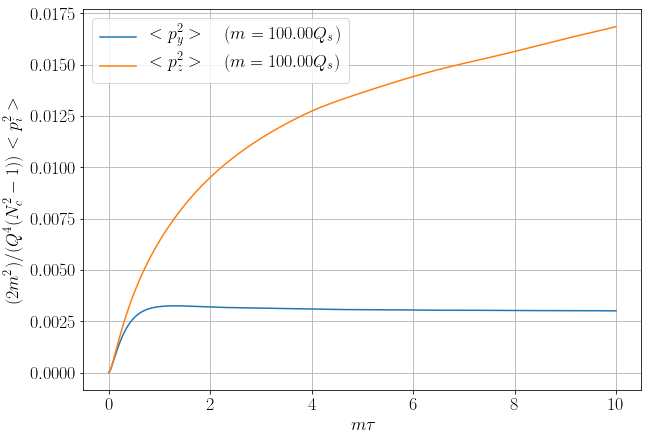

In [71]:
Nc = core.su.NC
c = 0.5 * (Nc ** 2 - 1)
m_ratios = [100.0]
for i, r in enumerate(ress):
    Q = 1.0 / m_ratios[i]
    plt.plot(r["tau"] / hbarc, r["p_qhat"][:, 1] / Q ** 4 / c,
             label="$<p_y^2> \quad (m = {:3.2f} Q_s)$".format(m_ratios[i]))
    plt.plot(r["tau"] / hbarc, r["p_qhat"][:, 2] / Q ** 4 / c,
             label="$<p_z^2> \quad (m = {:3.2f} Q_s)$".format(m_ratios[i]))

plt.xlabel("$m \\tau$")
plt.ylabel("$( 2 m^2 )/(Q^4 (N_c^2 - 1)) <p_i^2> $")
plt.legend()
plt.grid()
plt.show()

In [16]:
# Create some tables for pgfplots
unit_factor = 1.0 / (Q ** 4 * c)
m_ratios = [100.0]
r = ress[0]
data = [r["tau"] / hbarc]
Q = 1.0 / m_ratios[0]
data.append(r["p_qhat"][:, 1] * unit_factor)
data.append(r["p_qhat"][:, 2] * unit_factor)
data = np.array(data).T
data = np.nan_to_num(data)

np.savetxt("psquared_weak_su2.dat", data, header="m * tau, m^2 <p^2_y> / (Q^4 * c), m^2 <p^2_z> / (Q^4 * c)")

The comparison of this lattice data to the analytic expressions is performed in the notebook ```Momentum broadening in the dilute Glasma```.

## Initial field correlators in coordinate space

Now we use the ```correlators``` module to numerically compute the initial field correlators at $\tau = 0$.

In [ ]:
from curraun.correlators import Correlators

m_ratio = 100
hbarc = 0.197326
m = 1.0
g = 2
Q = m / m_ratio               # GeV
mu = Q / (g ** 2)             # GeV
L = 25.0 / m * hbarc          # fm

# simulation parameters
M = m
MU = mu
G = g
N = 1024
DT = 1 / 16.0
UV = 1000.0
NS = 1
NE = 400

Ezs = []
Bzs = []

with tqdm(total=NE, file=sys.stdout, miniters=1) as pbar:
    for e in range(NE):
        # initialization
        initial.DEBUG = False
        E0 = N / L * hbarc
        s = core.Simulation(N, DT, G)
        va = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NS)
        vb = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NS)
        initial.init(s, va, vb)

        if use_cuda:
            s.copy_to_device()

        corr = Correlators(s)
        corr.compute('Ez')
        Ez_c = corr.corr.copy()
        Ezs.append(Ez_c)
        corr.compute('Bz')
        Bz_c = corr.corr.copy()
        Bzs.append(Bz_c)

        pbar.set_description('Event {:3d}'.format(e))
        pbar.update(1)

Ezs = np.mean(np.array(Ezs), axis=0)
Bzs = np.mean(np.array(Bzs), axis=0)

Ezs_std = np.std(np.array(Ezs), axis=0)
Bzs_std = np.std(np.array(Bzs), axis=0)

res = {}
res["Ez"] = Ezs
res["Bz"] = Bzs

res["Ez_std"] = Ezs_std
res["Bz_std"] = Bzs_std

fname = "./initial_correlator_weak_su2.pickle"
pickle.dump(res, open(fname, "wb"))

In [50]:
m_ratio = 100
hbarc = 0.197326
m = 1.0
g = 2
Q = m / m_ratio               # GeV
mu = Q / (g ** 2)             # GeV
L = 25.0 / m * hbarc          # fm
E0 = N / L * hbarc

# simulation parameters
M = m
MU = mu
G = g
N = 1024
DT = 1 / 16.0
UV = 1000.0
NS = 1
NE = 400

# load the data
fname = "./initial_correlator_weak_su2.pickle"
res = pickle.load(open(fname, "rb"))

Next, we plot the data from the lattice simulations. The ```correlators``` module computes $\left< \mathrm{Tr} \left[ E_z(\mathbf x) U_{\mathbf x \rightarrow \mathbf y} E_z(\mathbf y) U_{\mathbf y \rightarrow \mathbf x})\right]\right>$. To better compare it to our analytical results we plot

$
c_E(r) = (T_F D_F D_A \frac{Q^4}{g^2})^{-1} \left< \mathrm{Tr} \left[ E_z(\mathbf x) U_{\mathbf x \rightarrow \mathbf y} E_z(\mathbf y) U_{\mathbf y \rightarrow \mathbf x})\right]\right>
$

We do the same for the longitudinal magnetic field.

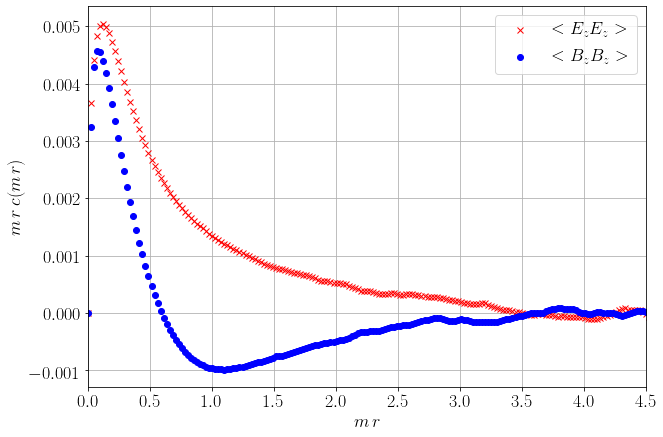

In [68]:
m_ratio = 100
hbarc = 0.197326
m = 1.0
g = 2
Qs = m / m_ratio              # GeV
mu = Q / (g ** 2)             # GeV
L = 25.0 / m * hbarc          # fm

N = 1024

Ezs, Bzs, Ezs_std, Bzs_std = res["Ez"], res["Bz"], res["Ez_std"], res["Bz_std"]
r = np.linspace(0, L/2, num=N//2) / hbarc  
G = 2
Nc = 2
f = (E0 ** 4 /  G ** 2) / (Qs ** 4 * 0.5 * Nc * (Nc ** 2 - 1) / G ** 2)
plt.plot(r, r * f * Ezs, 'rx', label="$<E_z E_z>$")
plt.plot(r, r * f * Bzs, 'bo', label="$<B_z B_z>$")

plt.xlabel("$m \, r$")
plt.ylabel("$m \, r \, c(m \, r)$")
plt.legend()
plt.xlim([0, 4.5])
plt.grid()
plt.show()


# export for pgfplots 
data = np.array([r, r * f * Ezs, r * f * Bzs]).T
np.savetxt("correlators_r_latt_su2.dat", data)

## Initial correlators in momentum space

We perform Hankel transformations of the spatial lattice data, i.e.

$
\tilde{c}_E(k) = \intop^\infty_0 dr \, r \, r c_E(r) J_0(k \, r)
$

The noisy data from the lattice at large $r$ can be smoothened cutting off the integral.

We compare to the analytic expressions for $\tilde c_E$ and $\tilde c_B$.

In [58]:
from scipy.integrate import nquad, simps

# since numba does not support scipy.special out of the box, we have to do this:
from numba.extending import get_cython_function_address
from numba import vectorize, njit
import ctypes

# J(0,x)
addr = get_cython_function_address("scipy.special.cython_special", "j0")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j0_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j0(x):
    return j0_fn(x)

@njit
def j0_njit(x):
    return vec_j0(x)

# J(1, x)
addr = get_cython_function_address("scipy.special.cython_special", "j1")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j1_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j1(x):
    return j1_fn(x)

@njit
def j1_njit(x):
    return vec_j1(x)

# Exact integrals from Mathematica
@vectorize('float64(float64)')
def cE(k):
    return (-2*(1 + 4/k**4 + 2/k**2)*np.sqrt(1 + 4/k**2) - 2*(1 + 8/k**6 + 16/k**4 + 6/k**2)*np.log(1/k) +
          (1 + 8/k**6 + 16/k**4 + 6/k**2) * np.log(((1 + np.sqrt(1 + 4/k**2) + 
        (2*(2 + np.sqrt(1 + 4/k**2) + k**(-2)))/k**2)*k**2)/2.))/(8.*(1 + 4/k**2)**2.5*k**2*np.pi)

@vectorize('float64(float64)')
def cB(k):
    return (-2*np.sqrt(1 + 4/k**2) - 2*(1 + 2/k**2)*np.log(1/k) + (1 + 2/k**2)*np.log(((1 + np.sqrt(1 + 4/k**2) + 
         (2*(2 + np.sqrt(1 + 4/k**2) + k**(-2)))/k**2)*k**2)/2.))/(8.*(1 + 4/k**2)**1.5*k**2*np.pi)

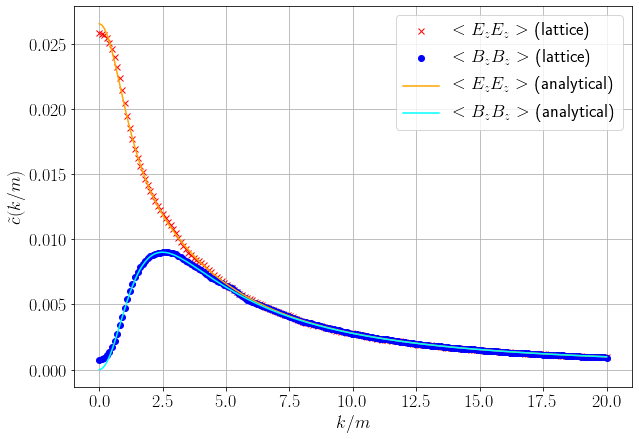

In [70]:
m_ratio = 100
hbarc = 0.197326
m = 1.0
g = 2
Qs = m / m_ratio               # GeV
mu = Q / (g ** 2)             # GeV
L = 25.0 / m * hbarc          # fm

N = 1024

lim = 4
n_lim = int(N * 1.0 / lim)
L_lim = L / lim

Ezs, Bzs, Ezs_std, Bzs_std = res["Ez"], res["Bz"], res["Ez_std"], res["Bz_std"]
r = np.linspace(0, L_lim, num=n_lim) / hbarc

G = 2
Nc = core.su.NC
f = 2 * np.pi * (E0 ** 4 /  G ** 2) / (Qs ** 4 * 0.5 * Nc * (Nc ** 2 - 1) / G ** 2)
p_range = np.linspace(0.001, 20.0, num=200)

Ez_m = [simps(x=r, y=f * r * Ezs[:n_lim] * vec_j0(p * r)) for p in p_range]
Bz_m = [simps(x=r, y=f *r * Bzs[:n_lim] * vec_j0(p * r)) for p in p_range]

plt.plot(p_range, Ez_m, 'rx', label="$<E_z E_z>$ (lattice)")
plt.plot(p_range, Bz_m, 'bo', label="$<B_z B_z>$ (lattice)")
plt.plot(p_range, cE(p_range), 'orange', label="$<E_z E_z>$ (analytical)")
plt.plot(p_range, cB(p_range), 'cyan', label="$<B_z B_z>$ (analytical)")
plt.xlabel("$k / m$")
plt.ylabel("$\\tilde{c} (k / m)$")
plt.legend()
plt.grid()

# export for pgfplots 
data = np.array([p_range, Ez_m, Bz_m]).T
np.savetxt("correlators_k_latt_su2.dat", data)